In [2]:
import pandas as pd
df=pd.read_csv('data.csv')

In [3]:
### define outliers 
mean = df['ncp'].mean()
std_dev = df['ncp'].std()
df['Outlier'] = (df['ncp'] < mean - 10*std_dev) | (df['ncp'] > mean + 10*std_dev)

### drop outliers 

df = df.drop(df[df['Outlier'] == True].index)


### drop nan

df = df.dropna() 

In [3]:
feature_columns = [ 'Lat', 'Lon', 'salt',
       'temp', 'press', 'neto2', 'Lon70', 'yrmn', 'jd', 'wsi', 'wsj','mli', 'CbPM', 'VGPM', 'CDOM', 'KD490',
       'PAR','POC', 'aot', 'Rrs_412', 'Rrs_443','Rrs_510']

In [4]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Assuming df is your DataFrame and it includes 'longitude', 'latitude' and 'ncp' columns

# Set a random seed for reproducibility
np.random.seed(0)

# First, let's prepare our features and target variable

target = df['ncp']
features = df[feature_columns]

# Standardize the features
scaler = StandardScaler()
features = scaler.fit_transform(features)

# Create a new column for spatial bins
# This is a simplistic way to create spatially distinct regions for StratifiedKFold
# For more complex scenarios, you might want to consider more sophisticated spatial clustering algorithms
df['spatial_bin'] = pd.cut(df['Lat'], bins=5)

# Split the data into training and testing sets using spatial bins
train_data, test_data, train_labels, test_labels = train_test_split(features, target, stratify=df['spatial_bin'], test_size=0.2, random_state=42)

# Now, let's create a basic feedforward neural network model
model = Sequential()
model.add(Dense(64, input_dim=train_data.shape[1], activation='relu'))  # Input layer
model.add(Dense(64, activation='relu'))  # Hidden layer
model.add(Dense(1))  # Output layer

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])
from keras.callbacks import EarlyStopping

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
# Train the model
history = model.fit(train_data, train_labels, epochs=100, batch_size=32,
                    validation_data=(test_data, test_labels),
                    callbacks=[early_stopping])


2023-07-27 20:39:33.071516: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-27 20:39:35.040526: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Epoch 1/100
8842/8842 [==============================] - 21s 2ms/step - loss: 135.4091 - mean_absolute_error: 5.7403 - val_loss: 93.3019 - val_mean_absolute_error: 4.7158
Epoch 2/100
8842/8842 [==============================] - 18s 2ms/step - loss: 82.2978 - mean_absolute_error: 4.4633 - val_loss: 74.9849 - val_mean_absolute_error: 4.2506
Epoch 3/100
8842/8842 [==============================] - 18s 2ms/step - loss: 66.6382 - mean_absolute_error: 4.0456 - val_loss: 63.0788 - val_mean_absolute_error: 3.9289
Epoch 4/100
8842/8842 [==============================] - 17s 2ms/step - loss: 57.1098 - mean_absolute_error: 3.7792 - val_loss: 54.3817 - val_mean_absolute_error: 3.6424
Epoch 5/100
8842/8842 [==============================] - 18s 2ms/step - loss: 50.6465 - mean_absolute_error: 3.5733 - val_loss: 49.0302 - val_mean_absolute_error: 3.4265
Epoch 6/100
8842/8842 [==============================] - 18s 2ms/step - loss: 45.7358 - mean_absolute_error: 3.4170 - val_loss: 42.7360 - val_mean_ab

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
# Calculate Mean Absolute Error for Neural Network
test_predictions = model.predict(test_data).flatten()
nn_mae = mean_absolute_error(test_labels, test_predictions)

# Annotation for Minimum Error
min_error_idx = np.argmin(history.history['val_mean_absolute_error'])
min_error = history.history['val_mean_absolute_error'][min_error_idx]

2211/2211 [==============================] - 4s 2ms/step


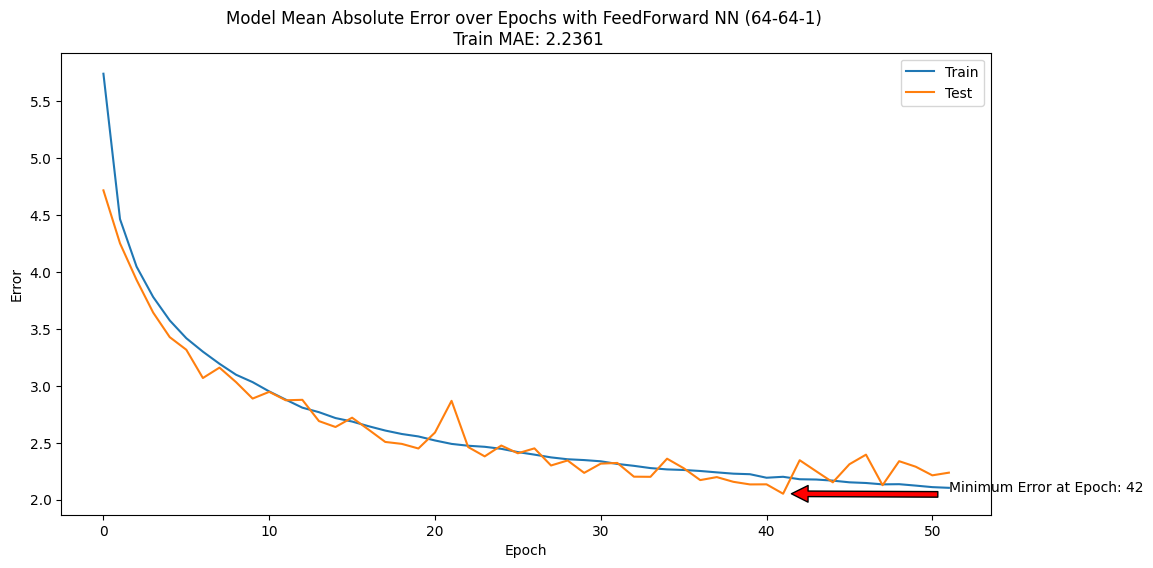

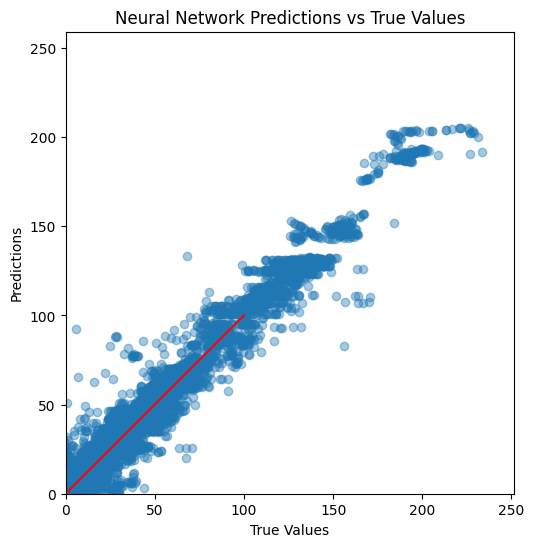

In [11]:

# Plotting training and validation Mean Absolute Error over epochs
plt.figure(figsize=(12, 6))
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title(f'Model Mean Absolute Error over Epochs with FeedForward NN (64-64-1) \n Train MAE: {nn_mae:.4f}')
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.annotate(f'Minimum Error at Epoch: {min_error_idx+1}', 
             xy=(min_error_idx, min_error), 
             xytext=(min_error_idx+10, min_error+0.02),
             arrowprops=dict(facecolor='red', shrink=0.05),
            )
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

# Plotting Actual vs Predicted values for Neural Network
plt.figure(figsize=(12, 6))
plt.scatter(test_labels, test_predictions, alpha=0.4)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
plt.plot([-100, 100], [-100, 100], color='red')
plt.title('Neural Network Predictions vs True Values')
plt.show()


In [12]:
# save 
model.save('nn.h5')